In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
import numpy.fft
from IPython.display import Audio

In [2]:
# returns sampling frequency and audio data in range [-1, 1]. prints audio length and sample rate 
def read_wav_audio(audio_relative_path):
    # fs is sample rate, audio_data is data from a .wav file
    fs, audio_data = wave.read(audio_relative_path)

    # audio length in seconds
    length = audio_data.shape[0] / fs

    print("Audio length:", round(length, 2), "seconds")
    print("Sample rate:", fs, "Hz")

    # convert dtype to float32. works on common data types specified in
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
    dtype = audio_data.dtype
    if dtype != np.float32:
        type_info = np.iinfo(dtype)
        audio_data = np.interp(audio_data, [type_info.min, type_info.max], [-1, 1])

    return fs, audio_data

In [3]:
audio_base_path = 'audio/'
audio_file_name = 'hawking01.wav'

In [4]:
fs, audio_data = read_wav_audio(audio_base_path + audio_file_name)

Audio length: 21.18 seconds
Sample rate: 11025 Hz


In [108]:
Audio(audio_data, rate=fs)

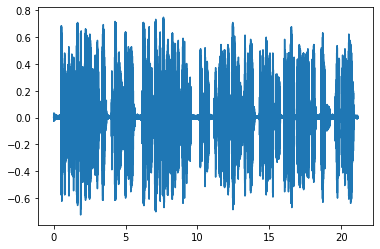

In [115]:
# plot audio over time
t = np.linspace(0, audio_data.shape[0] / fs, audio_data.shape[0])
plt.plot(t, audio_data)